In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'california-housing-prices:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5227%2F7876%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240903%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240903T165812Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dcdb20370a05df8cfce13b2ec7176b8134e2f72e9a8540e9d2a2a77895be152607a3bc0d01543a76690c29a97e92ce85db6b6fd45ea29410b0787b3393928828ae56fa0840580fa8037bbeefe43eedd0b07587216e81cacba03ae2667a82ec4d3b93642a6ed86b26598e38cb02877aa559867781a57a164e8c19022db2e1f66358324a6607451b91698e6a83d65c3362272d53a5f768cec4cc4fd6087bba8e5341bca7a35ab8553cd5045ec58d4fcdcc4fd3263e944bea23d5be4824e3c786de4ca1042909edde8ab5df6c6599058570d433f9f520b1d09ebbacd775026d00e01a57e8c620365c3282eba9f4b72ec50a27df63955c60590c8d158a9b7691d053a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 409382 bytes downloaded
Downloaded and uncompressed: california-housing-prices
Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import sklearn

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
housing = pd.read_csv("/kaggle/input/california-housing-prices/housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


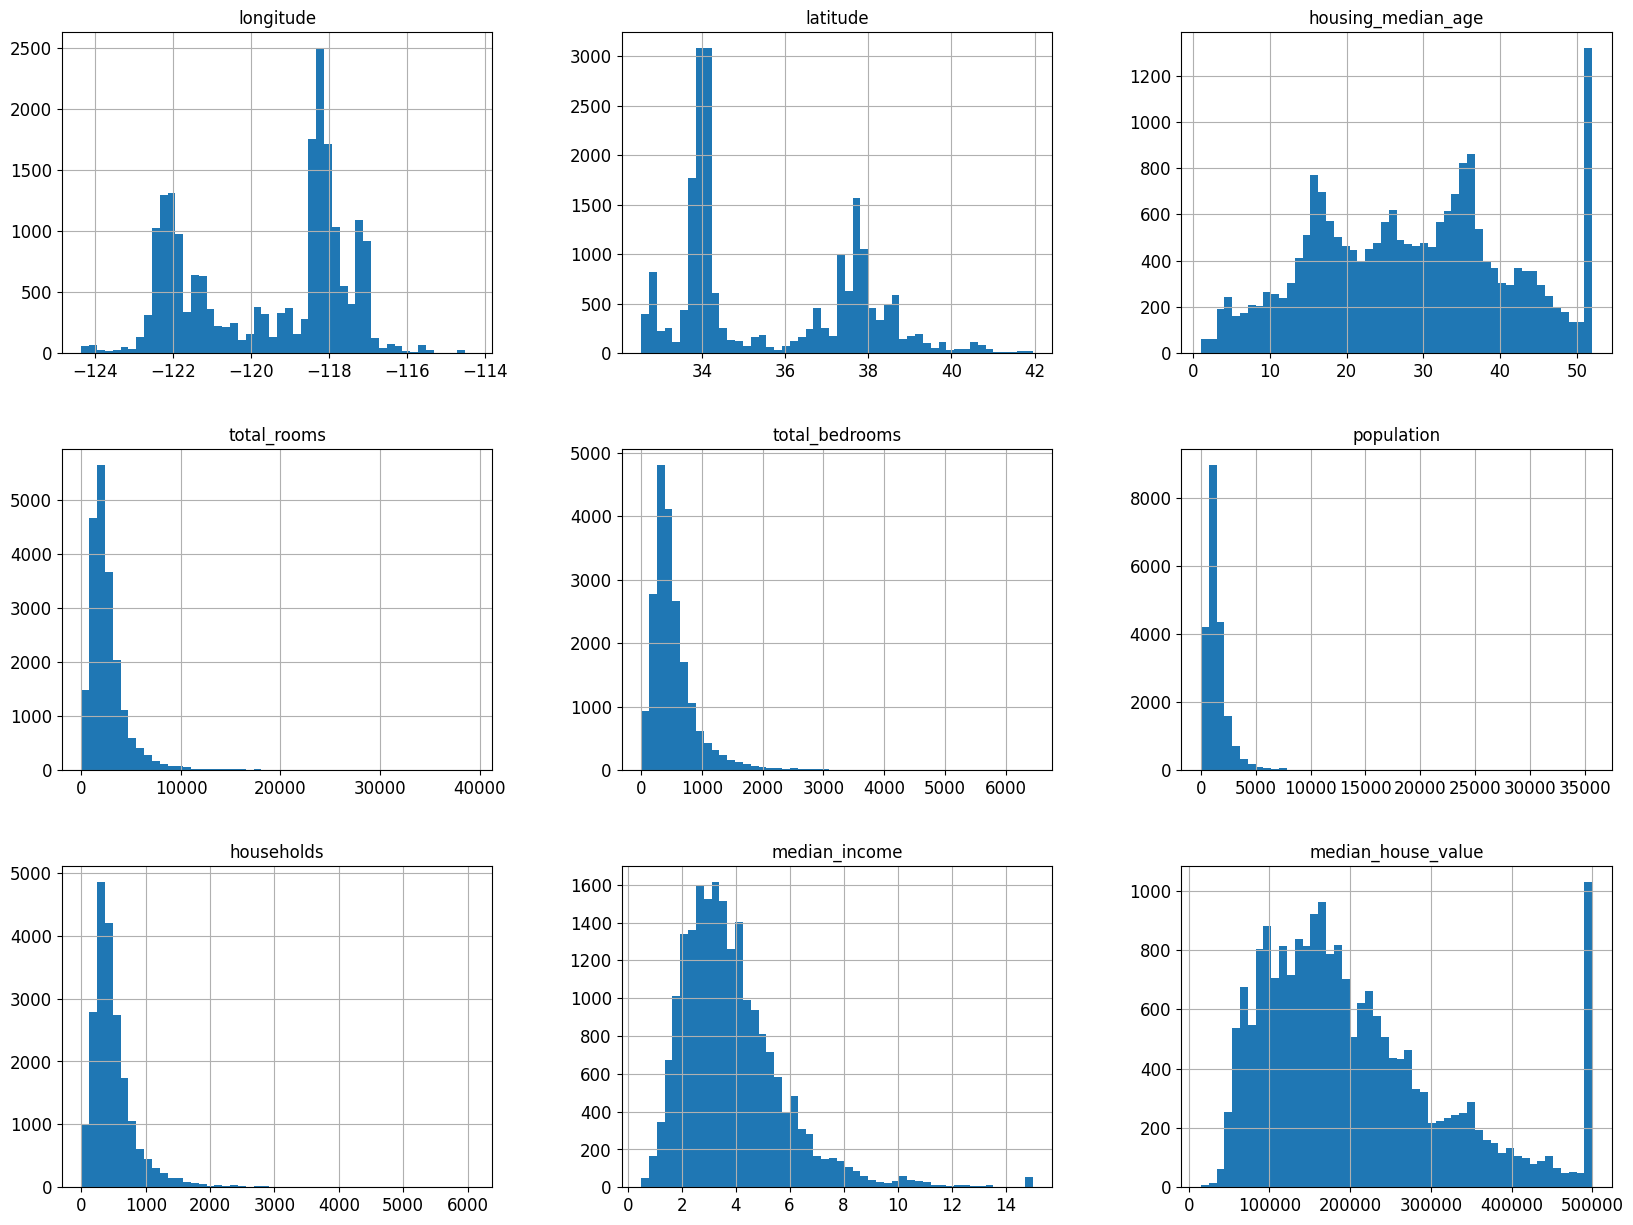

In [7]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
# New_housing = housing.drop(columns=['ocean_proximity'])
# correlation_matrix = New_housing.corr()
# HousePrice_correlation = correlation_matrix['median_house_value'].sort_values(ascending=False)
# print(HousePrice_correlation)

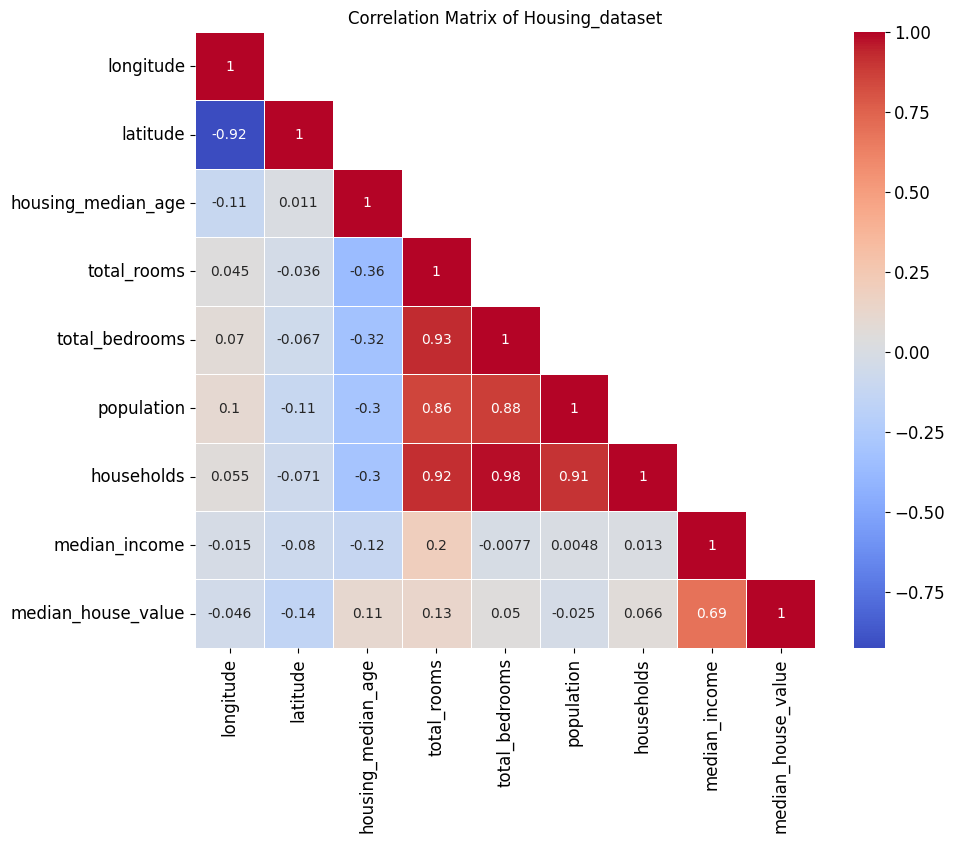

In [9]:
import seaborn as sns

New_housing = housing.drop(columns=['ocean_proximity'])
correlation_matrix = New_housing.corr()
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
sns.heatmap(correlation_matrix, mask = mask,annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Housing_dataset')
plt.show()

# Creating a Test Set data

In [10]:
np.random.seed(42)
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
len(train_set)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


**"from zlib import crc32"** This method ensures that the same data always goes to the same set across multiple runs, making it very useful for splitting datasets in a reproducible manner,

In [11]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

the housing dataset does not have an identifier column. The simplest
solution is to use the row index as the ID:

In [12]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [13]:
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


If you use the row index as a unique identifier, you need to make sure that new data
gets appended to the end of the dataset, and no row ever gets deleted. If this is not
possible, then you can try to use the most stable features to build a unique identifier.
For example, a district’s latitude and longitude are guaranteed to be stable for a few
million years, so you could combine them into an ID like so:1

In [14]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [15]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [17]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


<Axes: >

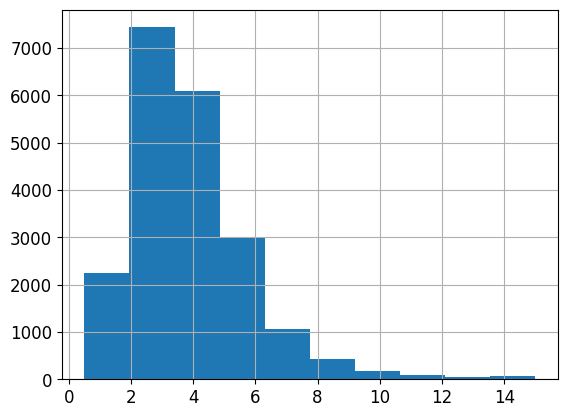

In [18]:
housing["median_income"].hist()

In [19]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

<Axes: >

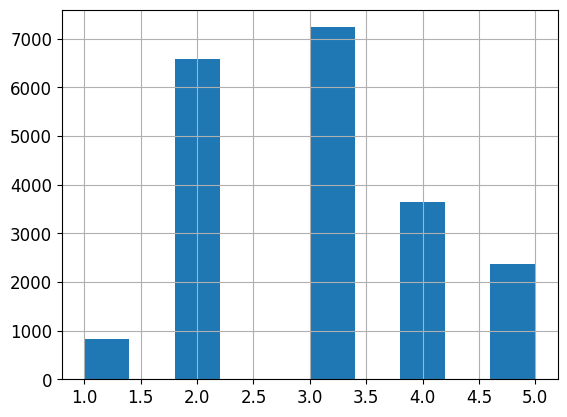

In [20]:
housing["income_cat"].hist()

The provided code is using StratifiedShuffleSplit from sklearn.model_selection to split a dataset into training and test sets while maintaining the distribution of a specified category.

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [22]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [23]:
housing["income_cat"].value_counts() / len(housing)

,count
income_cat,
3,0.350581
2,0.318847
4,0.176308
5,0.114438
1,0.039826


In [24]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [25]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
income_cat,,,,,
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


Removing the income_cat attribute so the data is back to its original
state:

In [26]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and Visualize the Data

In [27]:
housing = strat_train_set.copy()

Text(0.5, 1.0, 'bad_visualization_plot')

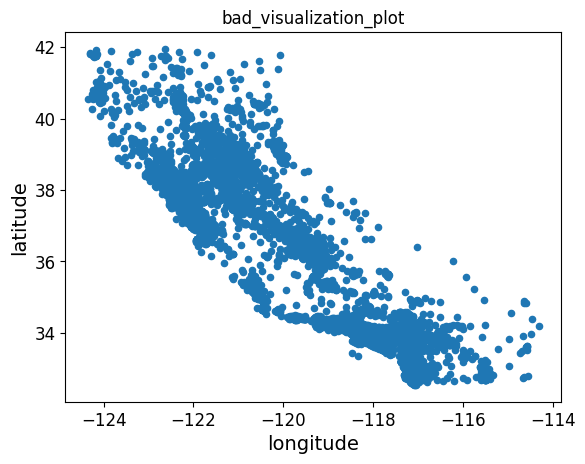

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.title(("bad_visualization_plot"))

Text(0.5, 1.0, 'better_visualization_plot')

<Figure size 600x400 with 0 Axes>

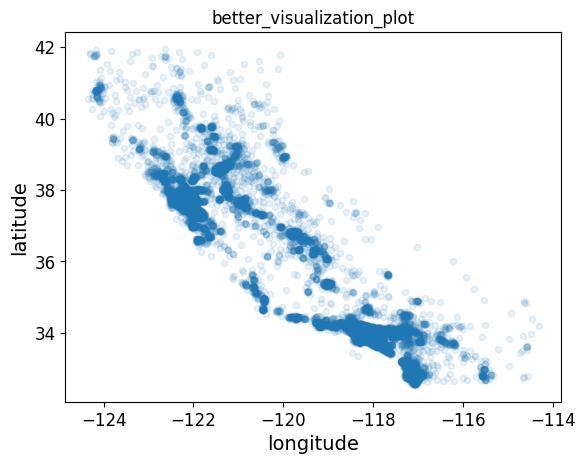

In [29]:
plt.figure(figsize=(6,4))
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.title("better_visualization_plot")

<Figure size 500x500 with 0 Axes>

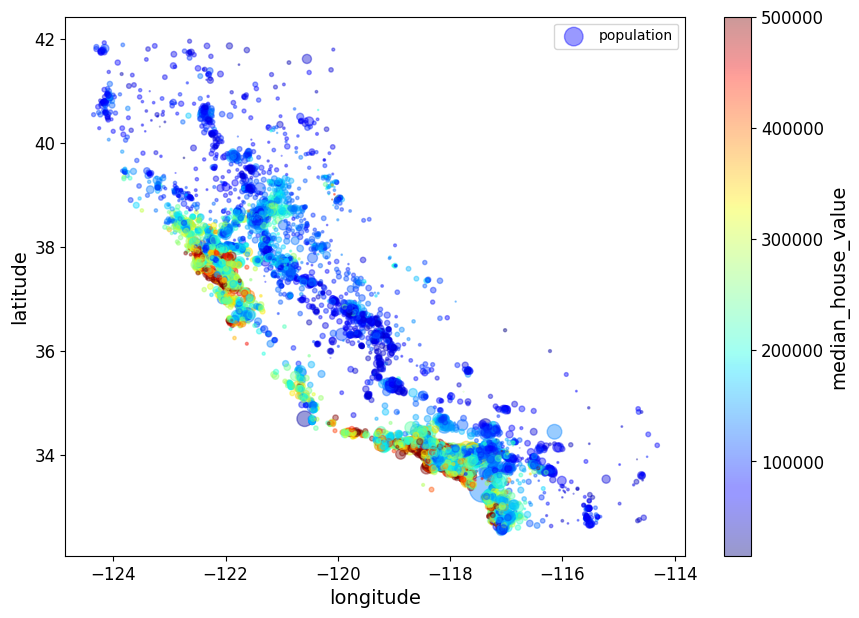

In [30]:
plt.figure(figsize=(5,5))
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(10,7),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In above Fig, The radius of each circle represents
the district’s population (option s), and the color represents the price (option c). We
will use a predefined color map (option cmap) called jet, which ranges from blue
(low values) to red (high prices):

# Looking for Correlations

In [31]:
numeric_housing = housing.select_dtypes(include=[np.number])
corr_matrix = numeric_housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.687151
total_rooms,0.135140
housing_median_age,0.114146
households,0.064590
total_bedrooms,0.047781
population,-0.026882
longitude,-0.047466
latitude,-0.142673


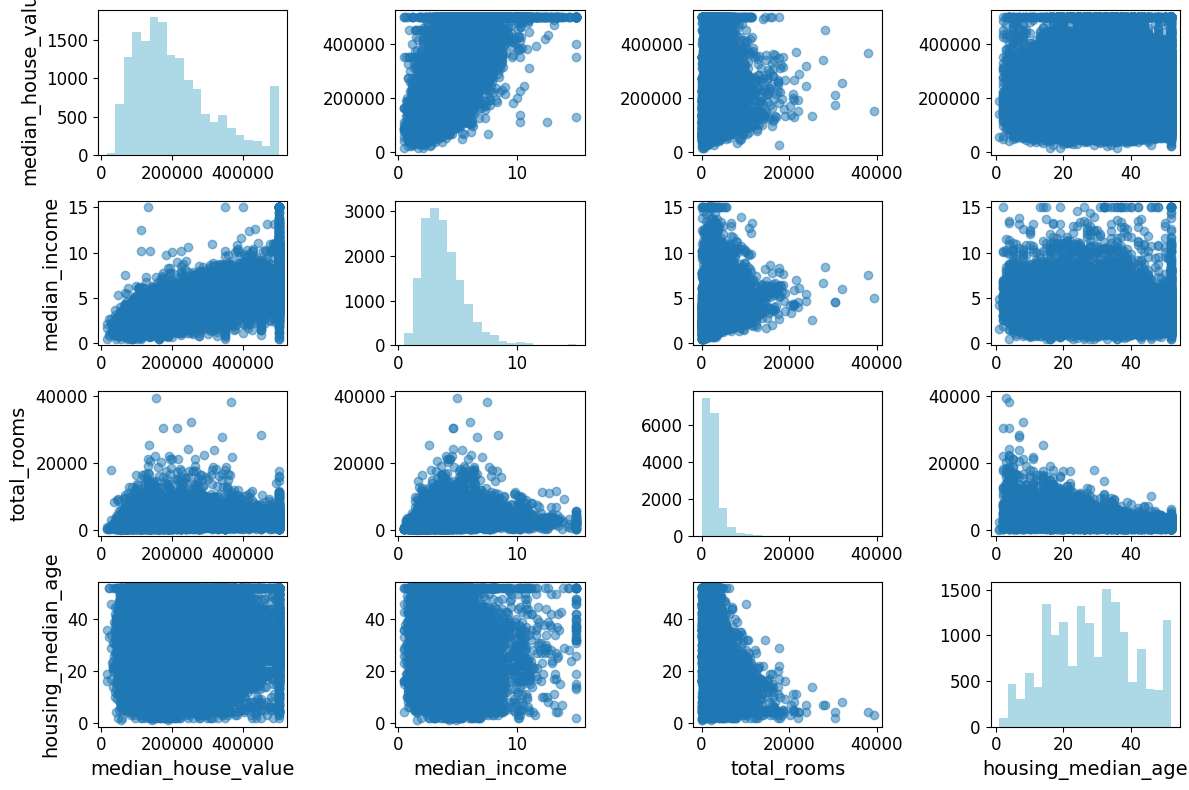

In [32]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
data = housing[attributes]

n = len(attributes)
fig, axes = plt.subplots(n, n, figsize=(12, 8))

for i in range(n):
  for j in range(n):
    if i == j:
      axes[i, j].hist(data.iloc[:, i], bins=20, color="lightblue")
    else:
      axes[i, j].scatter(data.iloc[:, j], data.iloc[:, i], alpha=0.5)
    if j == 0:
      axes[i, j].set_ylabel(attributes[i])
    if i == n - 1:
      axes[i, j].set_xlabel(attributes[j])

plt.tight_layout()
plt.show()


(0.0, 16.0, 0.0, 550000.0)

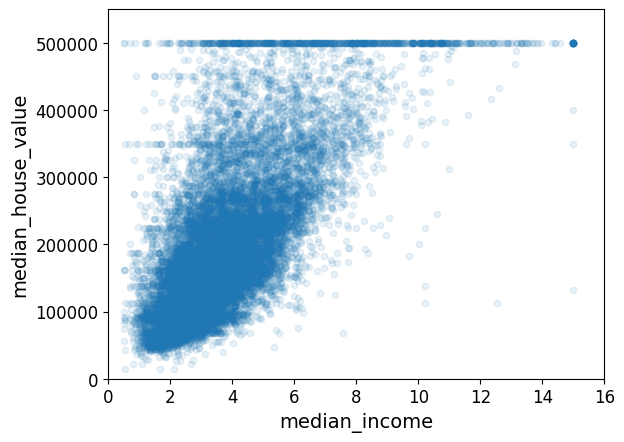

In [33]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

Above plot reveals a few things. First, the correlation is indeed very strong; you can
clearly see the upward trend and the points are not too dispersed. Second, the price
cap that we noticed earlier is clearly visible as a horizontal line at 500,000. But this
plot reveals other less obvious straight lines: a horizontal line around 450,000,
another around 350,000, perhaps one around 280,000, and a few more below that.
You may want to try removing the corresponding districts to prevent your algorithms
from learning to reproduce these data quirks.

# Experimenting with Attribute Combinations

In [34]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [35]:
numeric_housing = housing.select_dtypes(include=[np.number])
corr_matrix = numeric_housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.687151
rooms_per_household,0.146255
total_rooms,0.135140
housing_median_age,0.114146
households,0.064590
total_bedrooms,0.047781
population_per_household,-0.021991
population,-0.026882
longitude,-0.047466


# Prepare the Data for Machine Learning Algorithms

In [36]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

# Data Cleaning

* housing.dropna(subset=["total_bedrooms"])    # option 1
* housing.drop("total_bedrooms", axis=1)       # option 2
* median = housing["total_bedrooms"].median()  # option 3
* housing["total_bedrooms"].fillna(median, inplace=True)

To demonstrate each of them, let's create a copy of the housing dataset, but keeping only the rows that contain at least one null. Then it will be easier to visualize exactly what each option does:


```
housing_option1 = housing.copy()
housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1
housing_option1.loc[null_rows_idx].head()
```
```
housing_option2 = housing.copy()
housing_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2
housing_option2.loc[null_rows_idx].head()
```
```
housing_option3 = housing.copy()
median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3
housing_option3.loc[null_rows_idx].head()
```

In [37]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [38]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3

sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


In [39]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [40]:
housing_num = housing.select_dtypes(include=[np.number])
# housing_num = housing.drop("ocean_proximity", axis=1)

In [41]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [42]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [43]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [44]:
X = imputer.transform(housing_num)

In [45]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [46]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


In [47]:
imputer.strategy

'median'

In [48]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [49]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


# Handling Text and Categorical Attributes

In [50]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [51]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [52]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values.
(for example, categories 0 and 4 are
clearly more similar than categories 0 and 1). To fix this issue, a common solution is
to create one binary attribute per category: one attribute equal to 1 when the category
is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is
“INLAND” (and 0 otherwise), and so on. This is called one-hot encoding, because
only one attribute will be equal to 1 (hot), while the others will be 0 (cold).
 The new
attributes are sometimes called dummy attributes. Scikit-Learn provides a OneHotEn
coder class to convert categorical values into one-hot vectors

In [53]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

*Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very
useful when you have categorical attributes with thousands of categories. *

In [54]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Alternatively, we can set sparse=False when creating the OneHotEncoder:

In [55]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [56]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [57]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [58]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [59]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [60]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [61]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [62]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [63]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [64]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


# Feature Scaling

In [65]:
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


In [66]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [67]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

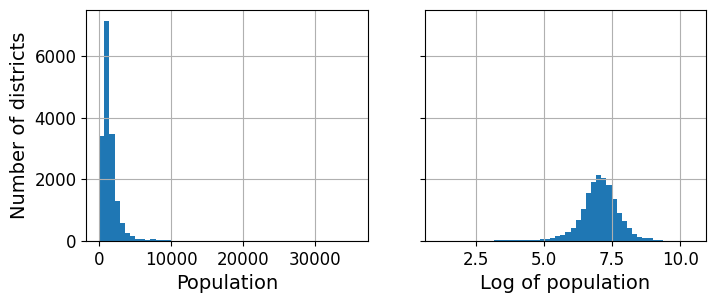

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()

In [69]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

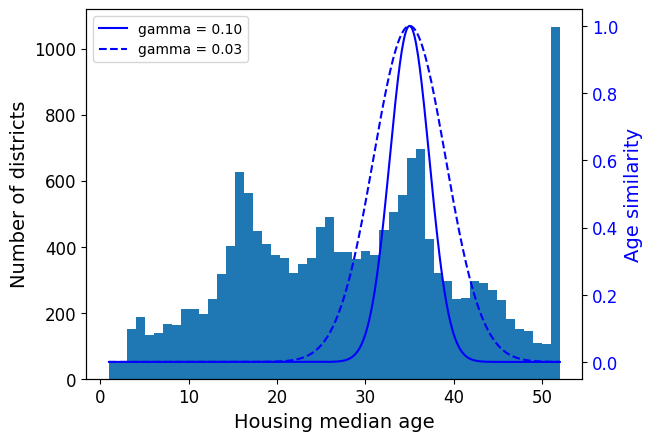

In [70]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
plt.show()

In [71]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [72]:
predictions

array([[135958.75805364],
       [309735.008975  ],
       [165232.3998617 ],
       [138162.41971241],
       [232903.1766333 ]])

In [73]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [74]:
predictions

array([135958.75805364, 309735.008975  , 165232.3998617 , 138162.41971241,
       232903.1766333 ])

# Custom Transformers

Although Scikit-Learn provides many useful transformers, you will need to write
your own for tasks such as custom cleanup operations or combining specific
attributes. You will want your transformer to work seamlessly with Scikit-Learn func‐
tionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inher‐
itance), all you need is to create a class and implement three methods: fit()
(returning self), transform(), and fit_transform(). You can get the last one for
free by simply adding TransformerMixin as a base class. Also, if you add BaseEstima
tor as a base class (and avoid \*args and \**kargs in your constructor) you will get
two extra methods (get_params() and set_params()) that will be useful for automatic hyperparameter tuning. For example, here is a small transformer class that adds
the combined attributes:

### **Using Scikit Function Transformer**

In [75]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [76]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])
age_simil_35

array([[2.73237224e-02],
       [8.93948745e-35],
       [3.03539138e-04],
       ...,
       [4.57533877e-08],
       [7.04065961e-20],
       [1.66155727e-03]])

In [77]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])
sf_simil

array([[0.86435873],
       [0.0076117 ],
       [0.18013578],
       ...,
       [0.94757821],
       [0.9636345 ],
       [0.61315569]])

In [78]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [79]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import numpy as np

class StandardScalerClone(BaseEstimator, TransformerMixin):

    def __init__(self, with_mean: bool = True):
        self.with_mean = with_mean

    def fit(self, X: np.ndarray, y=None) -> 'StandardScalerClone':
        X = self._validate_data(X, dtype=np.float64, ensure_2d=True)
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        # Store number of features seen during fit
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        # Check if the scaler was fitted
        check_is_fitted(self, ['mean_', 'scale_', 'n_features_in_'])
        # Validate input array
        X = self._validate_data(X, dtype=np.float64, ensure_2d=True, reset=False)
        # Ensure the input has the same number of features as during fitting
        if X.shape[1] != self.n_features_in_:
            raise ValueError(f"Number of features in X ({X.shape[1]}) does not match "
                             f"the number of features during fitting ({self.n_features_in_}).")

        if self.with_mean:
            X = X - self.mean_
        X_scaled = X / self.scale_
        return X_scaled


In [80]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters: int = 10, gamma: float = 1.0, random_state: int = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X: np.ndarray, y=None, sample_weight=None) -> 'ClusterSimilarity':
        X = self._validate_data(X, dtype=np.float64, ensure_2d=True)
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, n_init=10, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        check_is_fitted(self, 'kmeans_')
        X = self._validate_data(X, dtype=np.float64, ensure_2d=True, reset=False)
        X_transformed = rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
        return X_transformed

    def get_feature_names_out(self, names=None) -> list:
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


In [81]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

In [82]:
similarities[:3].round(2)

array([[0.  , 0.31, 0.  , 0.85, 0.  , 0.  , 0.  , 0.  , 0.16, 0.49],
       [0.11, 0.  , 0.  , 0.  , 0.94, 0.  , 0.  , 0.41, 0.  , 0.  ],
       [0.11, 0.  , 0.15, 0.  , 0.  , 0.37, 0.  , 0.02, 0.  , 0.  ]])

Also, housing_extra_attribs is a NumPy array, we've lost the column names (unfortunately, that's a problem with Scikit-Learn). To recover a DataFrame, you could run this:

### **Scikit Transformation Pipelines**

Now let's build a pipeline for preprocessing the numerical attributes:

In [83]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [84]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [85]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-0.94,  1.35,  0.03,  0.58,  0.64,  0.73,  0.56, -0.89],
       [ 1.17, -1.19, -1.72,  1.26,  0.78,  0.53,  0.72,  1.29]])

In [86]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

In [87]:
df_housing_num_prepared.head(3).round(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-0.94,1.35,0.03,0.58,0.64,0.73,0.56,-0.89
15502,1.17,-1.19,-1.72,1.26,0.78,0.53,0.72,1.29
2908,0.27,-0.13,1.22,-0.47,-0.55,-0.67,-0.52,-0.53


In [88]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

full_pipline = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

housing_prepared = full_pipeline.fit_transform(housing)

In [89]:
housing_prepared.shape

(16512, 13)

In [90]:
housing_prepared_fr = pd.DataFrame(
    housing_prepared, columns=full_pipeline.get_feature_names_out(),
    index=housing_num.index)
housing_prepared_fr.head(3).round(2)

,num__longitude,num__latitude,num__housing_median_age,num__total_rooms,num__total_bedrooms,num__population,num__households,num__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN
12655,-0.94,1.35,0.03,0.58,0.64,0.73,0.56,-0.89,0.0,1.0,0.0,0.0,0.0
15502,1.17,-1.19,-1.72,1.26,0.78,0.53,0.72,1.29,0.0,0.0,0.0,0.0,1.0
2908,0.27,-0.13,1.22,-0.47,-0.55,-0.67,-0.52,-0.53,0.0,1.0,0.0,0.0,0.0


In [91]:
def column_ratio(X):
  return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
  return ["ratio"]

def ratio_pipeline():
  return make_pipeline(
      SimpleImputer(strategy="median"),
      FunctionTransformer(column_ratio, feature_names_out=ratio_name),
      StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [92]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [93]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

# Select and Train a Model

## Training and Evaluating on the Training Set

In [94]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7a9...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a92ccaab670>)])),
                ('linearregression', LinearRegression())])

In [95]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)

array([ 70700., 288200., 186000., 189700., 270700.])

In [96]:
housing_labels.iloc[:5].values

array([ 72100., 279600.,  82700., 112500., 238300.])

In [97]:
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-1.9%, 3.1%, 124.9%, 68.6%, 13.6%


In [98]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse

69239.95619019211

In [99]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7a9...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a92ccaab670>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [100]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
tree_rmse

0.0

### Better Evaluation Using Cross-Validation

In [101]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [102]:
pd.Series(tree_rmses).describe()

,0
count,10.000000
mean,67430.987159
std,3623.038287
min,62118.730843
25%,64487.233745
50%,67826.258425
75%,69227.770860
max,74127.491554


In [103]:
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

,0
count,10.000000
mean,71697.574921
std,7907.808501
min,65132.889557
25%,68524.583894
50%,69772.522175
75%,71163.289136
max,93185.203688


In [104]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [105]:
pd.Series(forest_rmses).describe()

,0
count,10.000000
mean,47328.782275
std,2456.436091
min,43953.861521
25%,45272.501522
50%,47431.774424
75%,49045.891146
max,51153.378784


*Compare this RMSE measured using cross-validation (the "validation error") with the RMSE measured on the training set (the "training error"):*

In [106]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions,
                                 squared=False)
forest_rmse

17611.944346777196

# Fine-Tunning Model Using Grid Search

#### **Random Forest Regressor**

In [107]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7a92ccaab670>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [108]:
print(str(full_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__keep_empty_features', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__verbose_feature_names_out', 'prepr

In [109]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [110]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7a92cca...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a92cc7989d0>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [111]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43400,44475,45021,44299
13,15,8,43662,44478,45495,44545
14,15,10,44231,45167,46182,45193
7,10,6,44437,45257,46452,45382
9,10,6,44437,45257,46452,45382


# Randomized Search

In [112]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [113]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a92cc79a890>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a92cc7d23e0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [114]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41482,42969,43230,42560
8,32,7,41890,43529,43621,43013
5,42,4,41955,44061,43505,43174
0,41,16,42614,43528,44232,43458
2,23,8,42880,43378,44483,43580


# Analyze the Best Models and Their Errors

In [115]:
final_model = rnd_search.best_estimator_
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.07, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.18, 0.01, 0.02, 0.03,
       0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.  , 0.02, 0.02, 0.01, 0.02,
       0.  , 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.  , 0.03, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [116]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.1813831690256434, 'log__median_income'),
 (0.08244502861607364, 'cat__ocean_proximity_INLAND'),
 (0.0718801580236537, 'bedrooms__ratio'),
 (0.05817301838233788, 'rooms_per_house__ratio'),
 (0.049517115363919215, 'people_per_house__ratio'),
 (0.03248219147637665, 'geo__Cluster 2 similarity'),
 (0.028221062269895562, 'geo__Cluster 43 similarity'),
 (0.022653278091252674, 'geo__Cluster 6 similarity'),
 (0.02198898088685375, 'geo__Cluster 15 similarity'),
 (0.021199799837403884, 'geo__Cluster 10 similarity'),
 (0.01773675216603871, 'geo__Cluster 11 similarity'),
 (0.016812078342102393, 'geo__Cluster 24 similarity'),
 (0.0166587519568679, 'geo__Cluster 13 similarity'),
 (0.015499668492902265, 'geo__Cluster 1 similarity'),
 (0.014115237838677923, 'geo__Cluster 23 similarity'),
 (0.01354873263940505, 'geo__Cluster 25 similarity'),
 (0.012858660059159845, 'geo__Cluster 0 similarity'),
 (0.012738526960538106, 'remainder__housing_median_age'),
 (0.012678159416906736, 'geo__Cluster 36 similar

# Evaluate System on the Test Set

In [117]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

39565.359517373756


We can compute a 95% confidence interval for the test RMSE:



In [118]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([37712.09234569, 41335.61948717])

 ### Computes a confidence interval using a z-score

In [119]:
m = len(squared_errors)
mean = squared_errors.mean()
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(37712.649219257095, 41335.1114228974)

# Model persistence using joblib

In [120]:
import joblib

joblib.dump(final_model, "housing_model.pkl")

# final_model_reloaded = joblib.load("housing_model.pkl")

['housing_model.pkl']

# SciPy distributions for RandomizedSearchCV

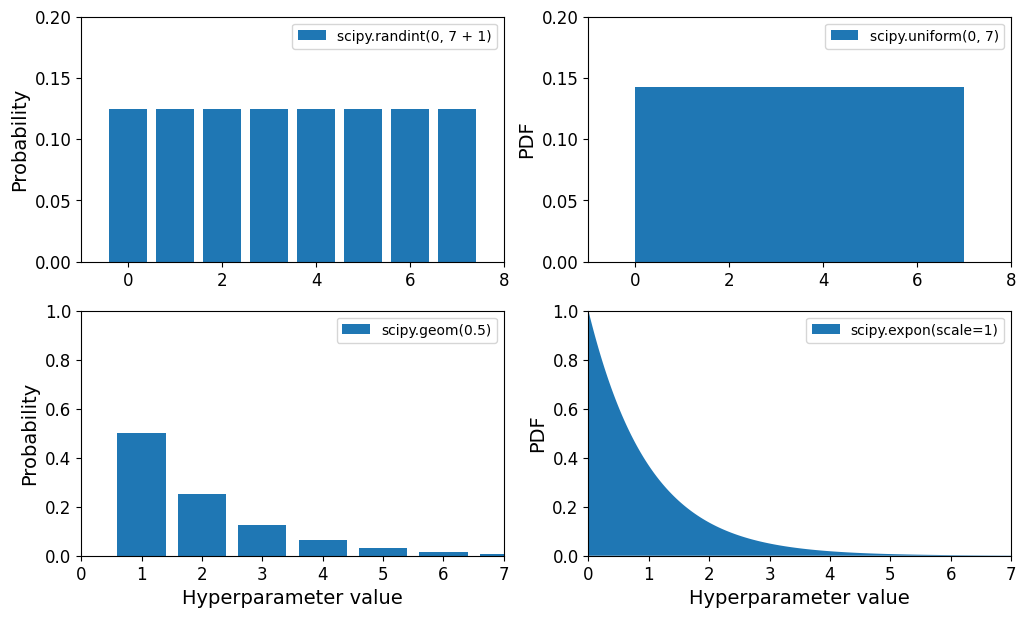

In [121]:
from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

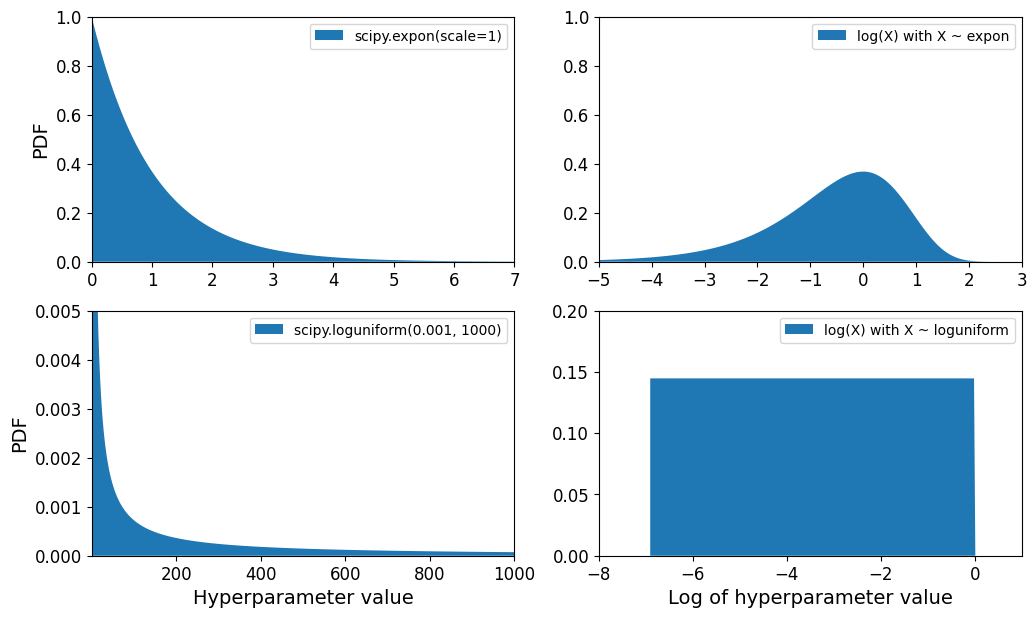

In [122]:
from scipy.stats import loguniform

xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))

xs3 = np.linspace(0.001, 1000, 500)
loguniform_distrib = loguniform(0.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_loguniform_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib,
                 label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib,
                 label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, loguniform_distrib,
                 label="scipy.loguniform(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_loguniform_distrib,
                 label="log(X) with X ~ loguniform")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])

plt.show()